# Part 5.

Ep 1/25:   0%|          | 0/390 [00:17<?, ?it/s]

Epoch [1/25] | D 15.080 | G 0.495


Ep 2/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [2/25] | D -2.662 | G 5.892


Ep 3/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [3/25] | D -5.728 | G 32.154


Ep 4/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [4/25] | D -5.645 | G 47.811


Ep 5/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [5/25] | D -5.358 | G 55.224


Ep 6/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [6/25] | D -5.220 | G 63.117


Ep 7/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [7/25] | D -5.030 | G 69.629


Ep 8/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [8/25] | D -4.836 | G 75.884


Ep 9/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [9/25] | D -4.645 | G 81.049


Ep 10/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [10/25] | D -4.496 | G 85.414


Ep 11/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [11/25] | D -4.330 | G 88.429


Ep 12/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [12/25] | D -4.180 | G 91.349


Ep 13/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [13/25] | D -4.046 | G 93.892


Ep 14/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [14/25] | D -3.946 | G 96.257


Ep 15/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [15/25] | D -3.848 | G 98.330


Ep 16/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [16/25] | D -3.748 | G 100.210


Ep 17/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [17/25] | D -3.639 | G 101.929


Ep 18/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [18/25] | D -3.559 | G 102.891


Ep 19/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [19/25] | D -3.464 | G 103.902


Ep 20/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [20/25] | D -3.389 | G 104.849


Ep 21/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [21/25] | D -3.294 | G 105.187


Ep 22/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [22/25] | D -3.258 | G 105.966


Ep 23/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [23/25] | D -3.188 | G 106.746


Ep 24/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [24/25] | D -3.106 | G 107.299


Ep 25/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [25/25] | D -3.049 | G 107.638


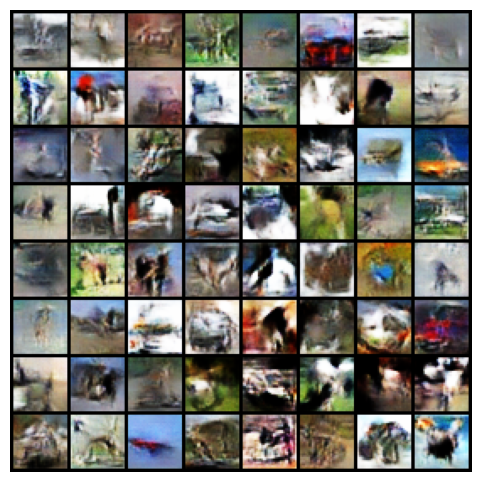

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 268MB/s]


saving real:   0%|          | 0/10000 [00:00<?, ?it/s]

IS 3.29 ± 0.07


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 171MB/s]
100%|██████████| 79/79 [00:38<00:00,  2.05it/s]


FID 72.94


In [1]:
import importlib.util, subprocess, sys, os, shutil, torch, random, math
def need(mod, pkg):
    if importlib.util.find_spec(mod) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
need("torchmetrics","torchmetrics[image]")
need("torch_fidelity","torch-fidelity")
need("pytorch_fid","pytorch-fid")
need("tqdm","tqdm")

from torch import nn, optim, autograd
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torchmetrics.image.inception import InceptionScore
from pytorch_fid.fid_score import calculate_fid_given_paths
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt, torch.multiprocessing as mp
mp.set_start_method("spawn", force=True)

if not (os.environ.get("COLAB_GPU") and os.environ["COLAB_GPU"]):
    raise SystemExit("Switch Colab to GPU and RESTART the runtime.")

device = torch.device("cuda")
torch.backends.cudnn.benchmark = True

# Configuration parameters
cfg = dict(
    batch= 128,
    workers= 2,
    nz= 100,
    ngf= 64,
    ndf= 64,
    epochs= 25,
    lr= 1e-4,
    beta1= 0.0,
    beta2= 0.9,
    fid_samples= 10_000,
    gp_lambda= 10
)
torch.manual_seed(1337); random.seed(1337)

# Initialize weights
def init_w(m):
    if isinstance(m,(nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight, 0, 0.02)

def save_flat(imgs, root, start):
    root.mkdir(parents=True, exist_ok=True)
    for i, img in enumerate(imgs):
        utils.save_image(img, root/f"{start+i:05d}.png", normalize=True, value_range=(-1,1))

tx = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,)*3,(0.5,)*3)])
ds = datasets.CIFAR10("./data", download=True, transform=tx)
fixed_real, _ = next(iter(DataLoader(ds, batch_size=64, shuffle=False, num_workers=0)))

dl = DataLoader(ds, batch_size=cfg["batch"], shuffle=True,
                num_workers=cfg["workers"], persistent_workers=True,
                drop_last=True, pin_memory=True)

# Define Generator network
class G(nn.Module):
    def __init__(s):
        super().__init__()
        s.main = nn.Sequential(
            nn.ConvTranspose2d(cfg["nz"], cfg["ngf"]*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(cfg["ngf"]*4), nn.ReLU(True),
            nn.ConvTranspose2d(cfg["ngf"]*4, cfg["ngf"]*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(cfg["ngf"]*2), nn.ReLU(True),
            nn.ConvTranspose2d(cfg["ngf"]*2, cfg["ngf"], 4, 2, 1, bias=False),
            nn.BatchNorm2d(cfg["ngf"]), nn.ReLU(True),
            nn.ConvTranspose2d(cfg["ngf"], 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(s, z): return s.main(z)

# Define Discriminator network
class D(nn.Module):
    def __init__(s):
        super().__init__()
        s.main = nn.Sequential(
            nn.Conv2d(3, cfg["ndf"], 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(cfg["ndf"], cfg["ndf"]*2, 4, 2, 1, bias=False),
            nn.LayerNorm([cfg["ndf"]*2, 8, 8]), nn.LeakyReLU(0.2, True),
            nn.Conv2d(cfg["ndf"]*2, cfg["ndf"]*4, 4, 2, 1, bias=False),
            nn.LayerNorm([cfg["ndf"]*4, 4, 4]), nn.LeakyReLU(0.2, True),
            nn.Conv2d(cfg["ndf"]*4, 1, 4, 1, 0, bias=False)
        )
    def forward(s, x): return s.main(x).view(-1)

G, D = G().to(device).apply(init_w), D().to(device).apply(init_w)
optG = optim.Adam(G.parameters(), lr=cfg["lr"], betas=(cfg["beta1"], cfg["beta2"]))
optD = optim.Adam(D.parameters(), lr=cfg["lr"], betas=(cfg["beta1"], cfg["beta2"]))
fixed_noise = torch.randn(64, cfg["nz"], 1, 1, device=device)

out = Path("wgangp_out"); out.mkdir(exist_ok=True)
fake_dir, real_dir = out/"fake", out/"real"
for p in (fake_dir, real_dir): shutil.rmtree(p, ignore_errors=True)

# Computes the gradient penalty for WGAN-GP
def gradient_penalty(D, real, fake):
    bs = real.size(0)
    eps = torch.rand(bs, 1, 1, 1, device=device)
    interp = (eps * real + (1-eps) * fake).requires_grad_(True)
    d_interp = D(interp)
    grads = autograd.grad(outputs=d_interp, inputs=interp,
                          grad_outputs=torch.ones_like(d_interp),
                          create_graph=True, retain_graph=True)[0]
    norm = grads.view(bs, -1).norm(2, dim=1)
    return ((norm - 1)**2).mean()

G_losses = []
D_losses = []

# Training phase
for ep in range(1, cfg["epochs"]+1):
    D_sum, G_sum = 0, 0
    for real, _ in tqdm(dl, leave=False, desc=f"Ep {ep}/{cfg['epochs']}"):
        bs = real.size(0); real = real.to(device)
        for _ in range(5):
            # Train Discriminator
            D.zero_grad(set_to_none=True)
            z = torch.randn(bs, cfg["nz"], 1, 1, device=device)
            fake = G(z).detach()
            d_real = D(real)
            d_fake = D(fake)
            gp = gradient_penalty(D, real, fake)
            lossD = (d_fake.mean() - d_real.mean()) + cfg["gp_lambda"] * gp
            lossD.backward()
            optD.step()
        D_sum += lossD.item()

        # Train Generator
        G.zero_grad(set_to_none=True)
        z = torch.randn(bs, cfg["nz"], 1, 1, device=device)
        fake = G(z)
        lossG = -D(fake).mean()
        lossG.backward()
        optG.step()
        G_sum += lossG.item()

    print(f"Epoch [{ep}/25] | D {D_sum/len(dl):.3f} | G {G_sum/len(dl):.3f}")

    G_losses.append(G_sum / len(dl))
    D_losses.append(D_sum / len(dl))

    with torch.no_grad():
        grid_fake = G(fixed_noise).cpu()
        utils.save_image(grid_fake, out/f"fake_{ep:03d}.png", nrow=8, normalize=True, value_range=(-1,1))
        utils.save_image(fixed_real, out/f"real_{ep:03d}.png", nrow=8, normalize=True, value_range=(-1,1))

plt.figure(figsize=(6,6)); plt.axis("off")
plt.imshow(utils.make_grid(grid_fake, nrow=8, normalize=True, value_range=(-1,1)).permute(1,2,0)); plt.show()

# Evaluate model using IS and FID
metric = InceptionScore(normalize=True).to(device)
saved = 0
with torch.no_grad():
    while saved < cfg["fid_samples"]:
        chunk = min(cfg["batch"], cfg["fid_samples"]-saved)
        imgs = G(torch.randn(chunk, cfg["nz"], 1, 1, device=device)).cpu()
        save_flat(imgs, fake_dir, saved)
        metric.update(imgs.to(device)); saved += imgs.size(0)
for i in tqdm(range(cfg["fid_samples"]), desc="saving real"):
    save_flat(ds[i][0].unsqueeze(0), real_dir, i)

# Report final scores
is_mean, is_std = metric.compute()
print(f"IS {is_mean:.2f} ± {is_std:.2f}")
fid = calculate_fid_given_paths([str(real_dir), str(fake_dir)], batch_size=128, device=device, dims=2048)
print(f"FID {fid:.2f}")

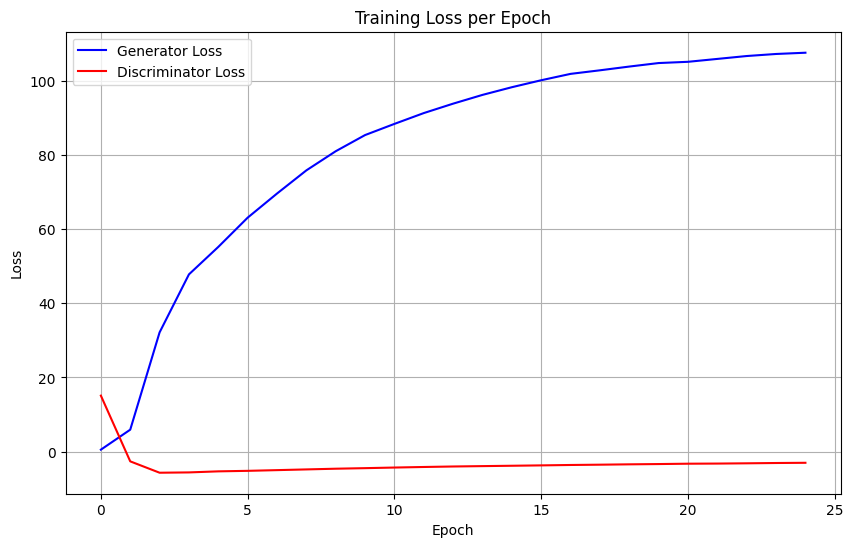

In [2]:
plt.figure(figsize=(10, 6))
plt.plot(G_losses, label="Generator Loss", color="blue")
plt.plot(D_losses, label="Discriminator Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()